In [17]:
import sys
import os
import pandas as pd # type: ignore
import numpy as np # type: ignore
from scipy.stats import zscore # type: ignore
sys.path.append(os.path.abspath('C:/Users/nejat/AIM Projects/Telecommunication Data Analysis/src'))
from db_connection import PostgresConnection
from data_cleaning import preprocess_data  

def load_data():
    query = "SELECT * FROM xdr_data"
    db = PostgresConnection(dbname='tellco', user='postgres', password='237132')
    db.connect()
    result = db.execute_query(query)
    df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
    db.close_connection()
    print(df.head()) 
    return df

def analyze_handsets(df):
    # Identify top 10 handsets
    top_handsets = df['Handset Type'].value_counts().head(10)
    print("Top 10 handsets:")
    print(top_handsets)
    
    # Identify top 3 handset manufacturers
    top_manufacturers = df['Handset Manufacturer'].value_counts().head(3)
    print("\nTop 3 manufacturers:")
    print(top_manufacturers)
    
    # Top 5 handsets per top 3 manufacturers
    for manufacturer in top_manufacturers.index:
        top_handsets_manufacturer = df[df['Handset Manufacturer'] == manufacturer]['Handset Type'].value_counts().head(5)
        print(f"\nTop 5 handsets for {manufacturer}:")
        print(top_handsets_manufacturer)

def aggregate_user_behavior(df):
    aggregated_data = df.groupby('IMSI').agg({
        'Bearer Id': 'count',
        'Dur. (ms)': 'sum',
        'Total DL (Bytes)': 'sum',
        'Total UL (Bytes)': 'sum',
        'HTTP DL (Bytes)': 'sum',
        'HTTP UL (Bytes)': 'sum',
        'Social Media DL (Bytes)': 'sum',
        'Social Media UL (Bytes)': 'sum',
        'Youtube DL (Bytes)': 'sum',
        'Youtube UL (Bytes)': 'sum',
        'Netflix DL (Bytes)': 'sum',
        'Netflix UL (Bytes)': 'sum',
        'Google DL (Bytes)': 'sum',
        'Google UL (Bytes)': 'sum',
        'Email DL (Bytes)': 'sum',
        'Email UL (Bytes)': 'sum',
        'Gaming DL (Bytes)': 'sum',
        'Gaming UL (Bytes)': 'sum',
        'Other DL (Bytes)': 'sum',
        'Other UL (Bytes)': 'sum'
    }).reset_index()
    return aggregated_data

df = load_data()
df = preprocess_data(df)  
    
analyze_handsets(df)
    
user_behavior_df = aggregate_user_behavior(df)
print("\nUser Behavior Aggregated Data:")
print(user_behavior_df.head())


Connected to PostgreSQL database!
Connection closed.
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L7

In [18]:
def describe_variables(df):
    print("Data Types and Summary Statistics:")
    print(df.dtypes)
    print("\nSummary Statistics:")
    print(df.describe(include='all'))

describe_variables(df)

Data Types and Summary Statistics:
Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)

In [19]:
def segment_users_by_decile(df):
    df['Total Duration'] = df['Dur. (ms)'] / 1000  # Convert to seconds
    df['Total Data'] = df['Total DL (Bytes)'] + df['Total UL (Bytes)']
    
    # Segment users into deciles
    df['Decile'] = pd.qcut(df['Total Duration'], 10, labels=False)
    
    decile_summary = df.groupby('Decile').agg({
        'Total Data': 'sum',
        'Total Duration': 'sum'
    }).reset_index()
    
    print("\nDecile Summary:")
    print(decile_summary)

segment_users_by_decile(df)


Decile Summary:
   Decile    Total Data  Total Duration
0       0  4.790498e+12      192427.488
1       1  4.802174e+12      367350.184
2       2  4.819437e+12      596879.061
3       3  4.764951e+12      818790.083
4       4  4.774164e+12      881830.904
5       5  4.814992e+12     1007706.959
6       6  4.738380e+12     1215552.990
7       7  4.806000e+12     1432270.028
8       8  4.812184e+12     1650524.063
9       9  4.816162e+12     2202128.527


In [21]:
def analyze_basic_metrics(df):
    numeric_df = df.select_dtypes(include=[np.number])
    
    metrics = {
        'mean': numeric_df.mean(),
        'median': numeric_df.median(),
        'std_dev': numeric_df.std(),
        'min': numeric_df.min(),
        'max': numeric_df.max()
    }
    
    for metric_name, metric_values in metrics.items():
        print(f"\n{metric_name.capitalize()}:")
        print(metric_values)

analyze_basic_metrics(df)


Mean:
Bearer Id                                   9.975812e+18
Start ms                                    4.991638e+02
End ms                                      4.983039e+02
Dur. (ms)                                   1.072263e+05
IMSI                                        2.082017e+14
MSISDN/Number                               3.371757e+10
IMEI                                        4.199963e+13
Avg RTT DL (ms)                             7.853459e+01
Avg RTT UL (ms)                             9.509510e+00
Avg Bearer TP DL (kbps)                     1.743851e+03
Avg Bearer TP UL (kbps)                     1.137884e+02
TCP DL Retrans. Vol (Bytes)                 1.771392e+07
TCP UL Retrans. Vol (Bytes)                 6.828574e+05
DL TP < 50 Kbps (%)                         9.908845e+01
50 Kbps < DL TP < 250 Kbps (%)              4.565628e-01
250 Kbps < DL TP < 1 Mbps (%)               1.413444e-01
DL TP > 1 Mbps (%)                          7.907880e-02
UL TP < 10 Kbps (%)     

In [22]:
def non_graphical_univariate_analysis(df):
    dispersion_params = df.select_dtypes(include=[np.number]).agg(['var', 'std', 'mean'])
    print("\nDispersion Parameters:")
    print(dispersion_params)

non_graphical_univariate_analysis(df)


Dispersion Parameters:
         Bearer Id      Start ms        End ms     Dur. (ms)          IMSI  \
var   8.279566e+36  83039.950240  82848.154392  3.703174e+09  1.966647e+18   
std   2.877423e+18    288.166532    287.833553  6.085371e+04  1.402372e+09   
mean  9.975812e+18    499.163817    498.303872  1.072263e+05  2.082017e+14   

      MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
var    3.675342e+17  3.006750e+26     13627.455934       169.136974   
std    6.062460e+08  1.733998e+13       116.736695        13.005267   
mean   3.371757e+10  4.199963e+13        78.534589         9.509510   

      Avg Bearer TP DL (kbps)  ...  Netflix UL (Bytes)  Gaming DL (Bytes)  \
var              4.199494e+07  ...        4.045775e+13       5.949677e+16   
std              6.480351e+03  ...        6.360641e+06       2.439196e+08   
mean             1.743851e+03  ...        1.098203e+07       4.222450e+08   

      Gaming UL (Bytes)  Other DL (Bytes)  Other UL (Bytes)  Total UL

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


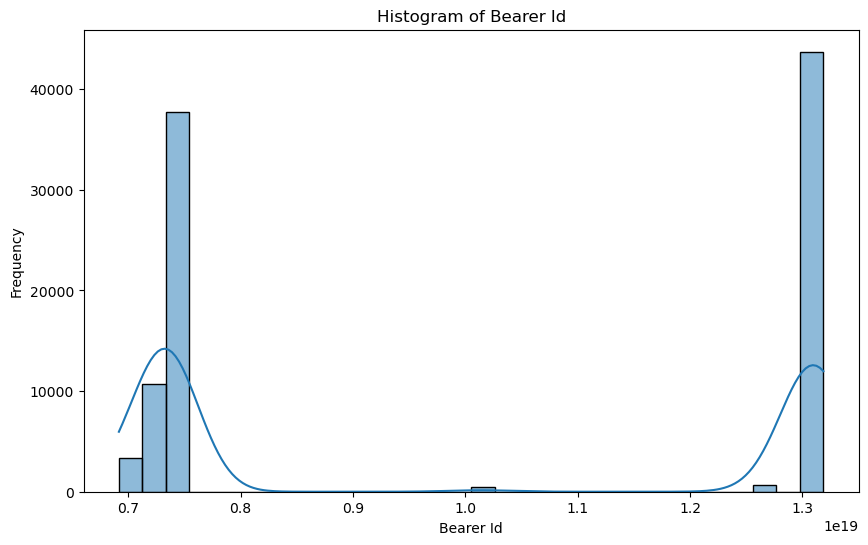

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


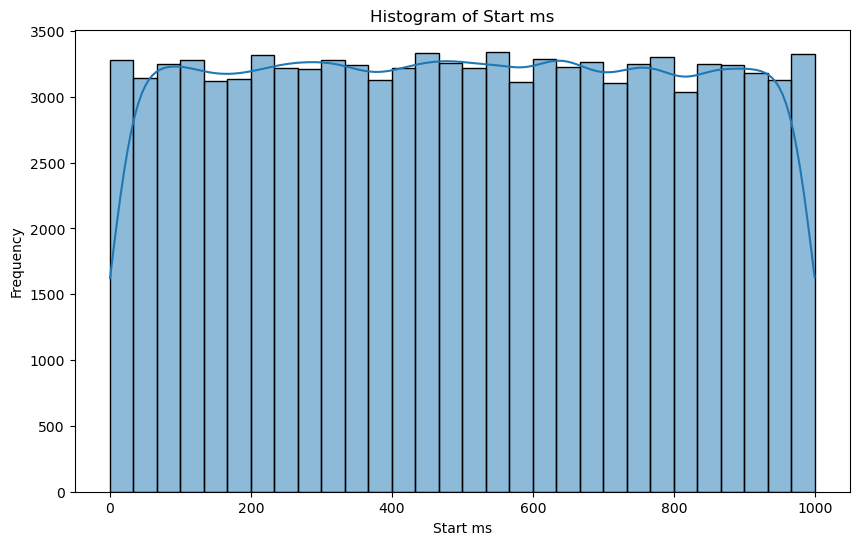

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


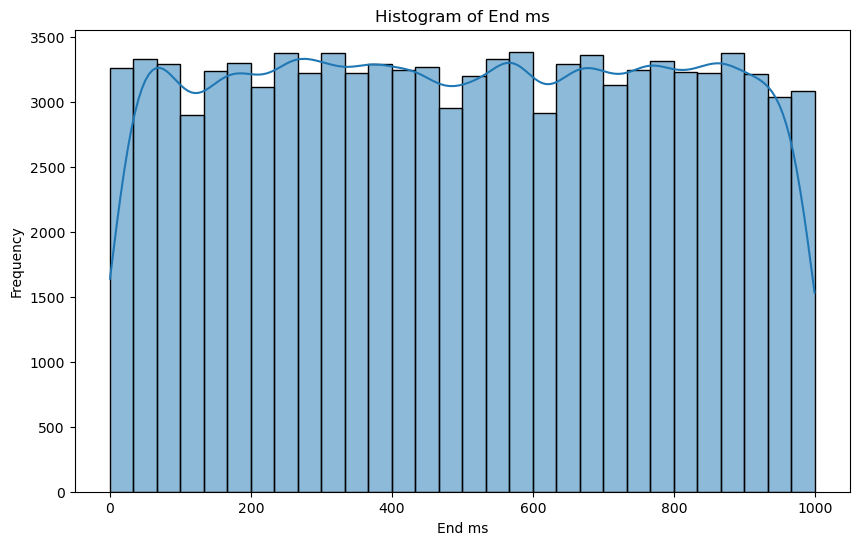

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


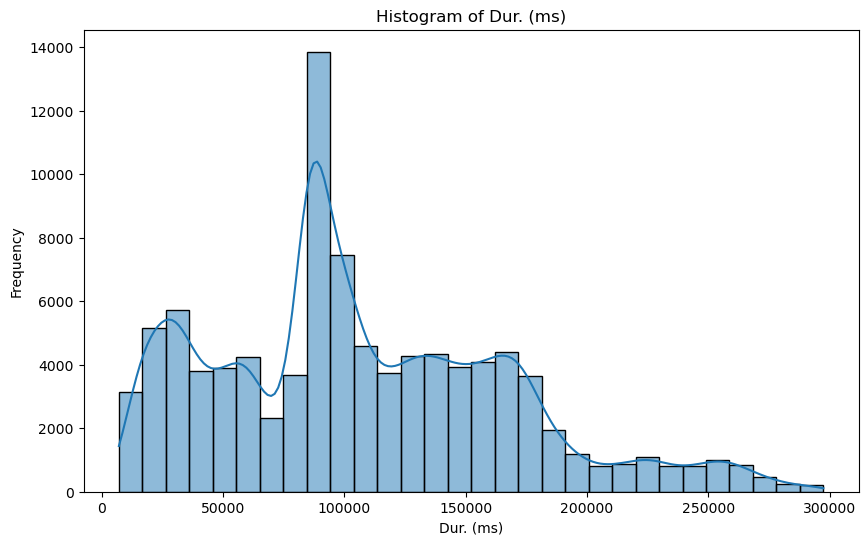

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


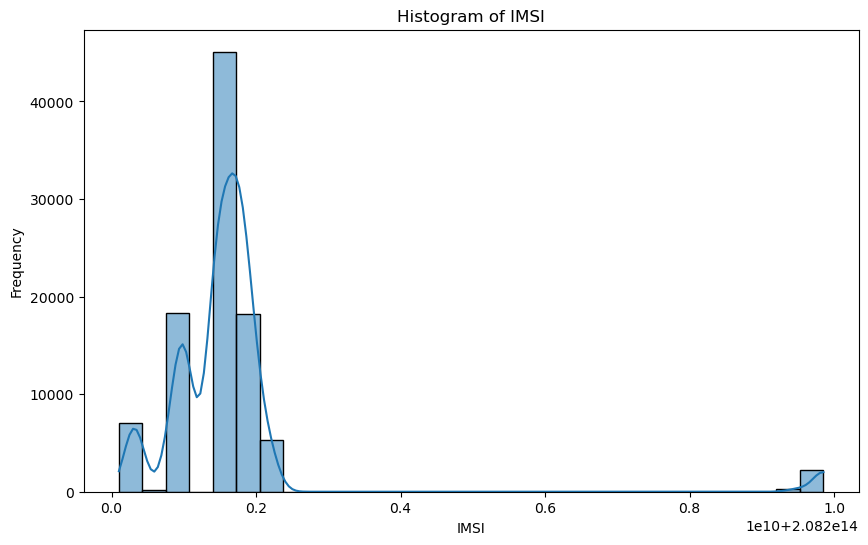

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


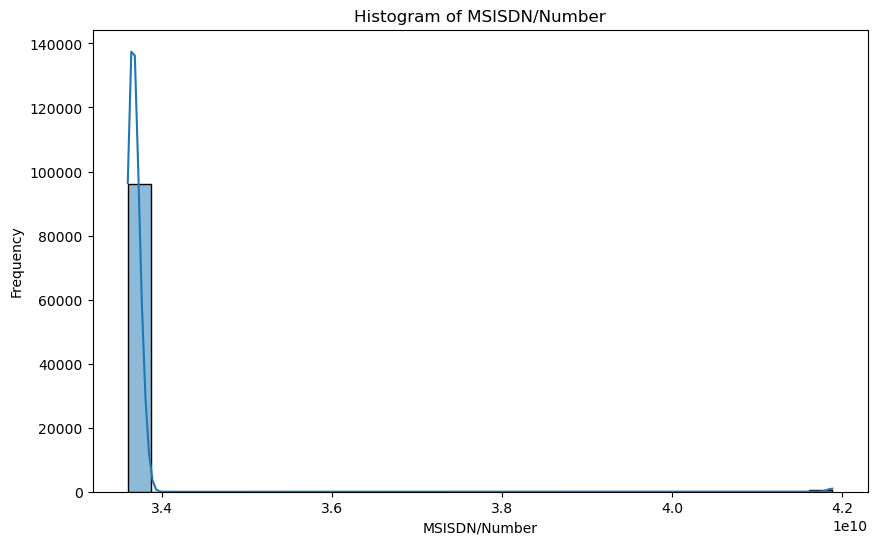

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


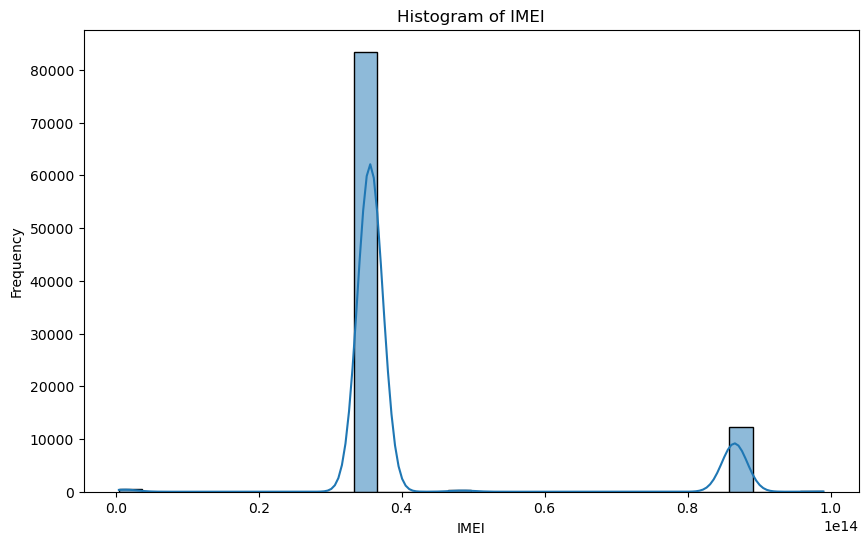

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


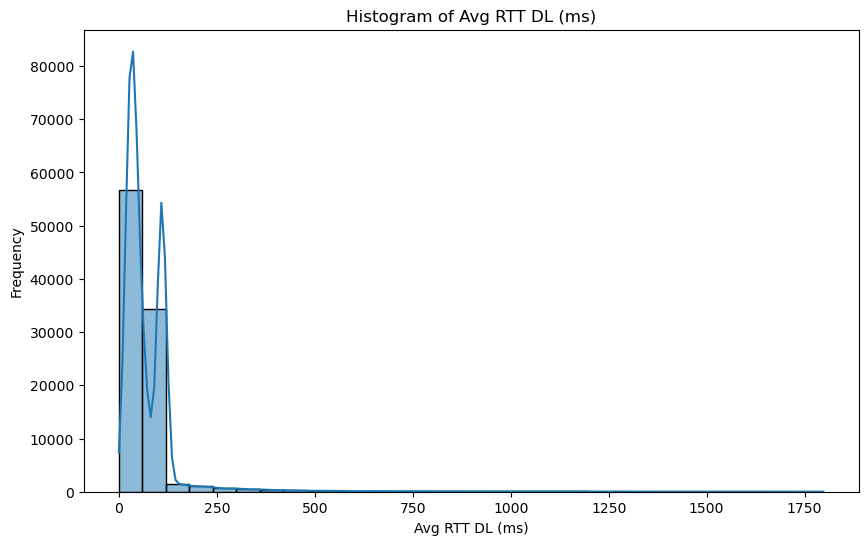

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


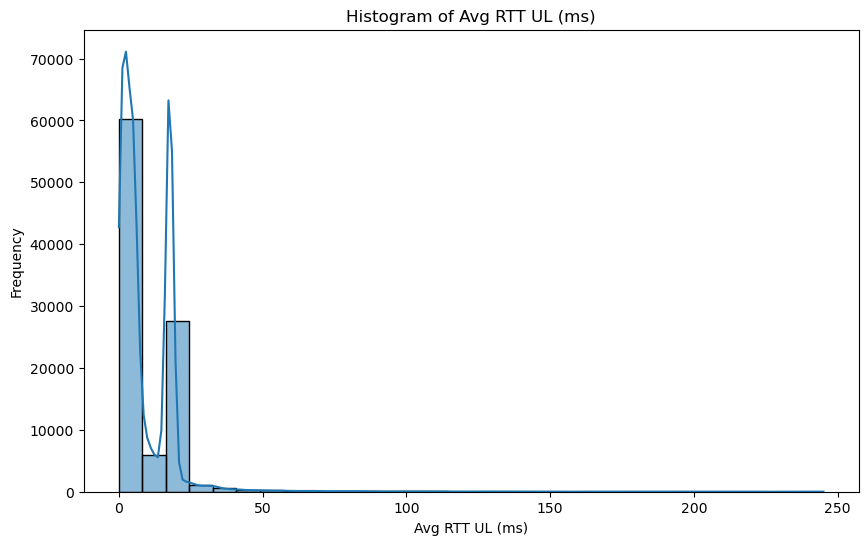

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


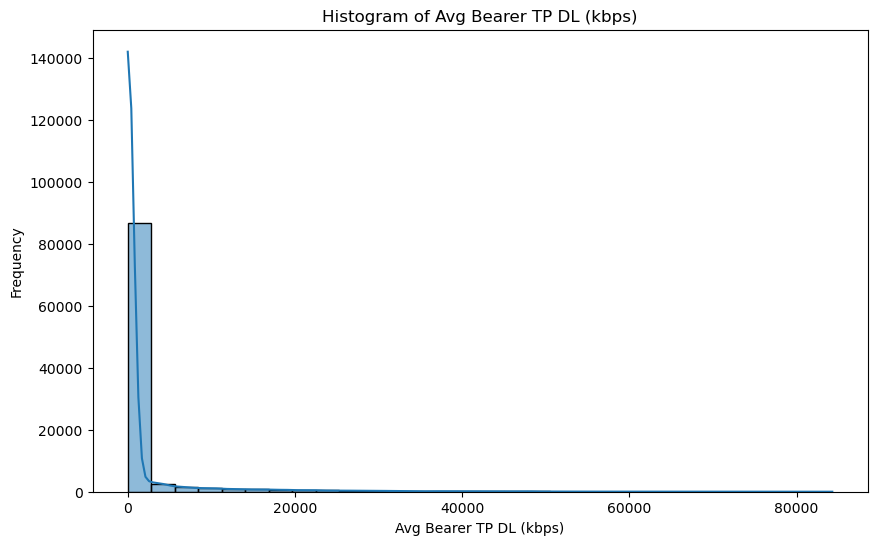

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


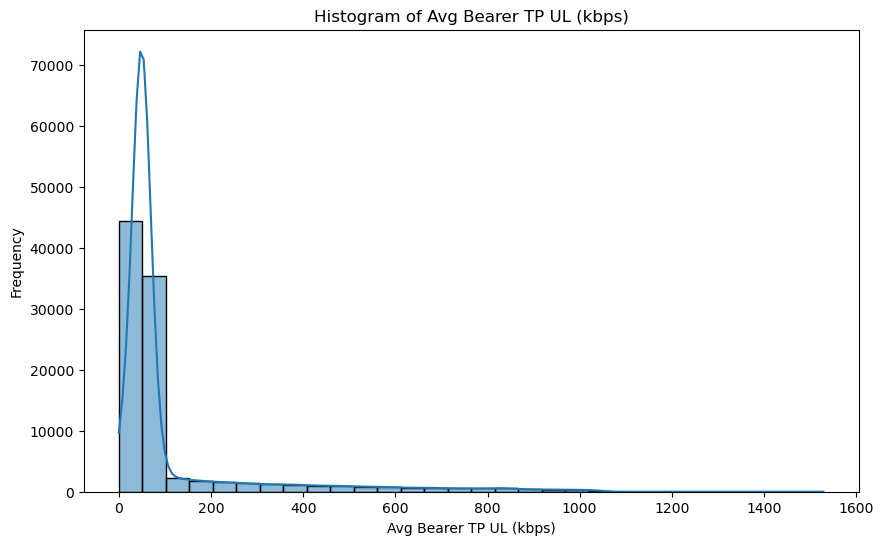

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


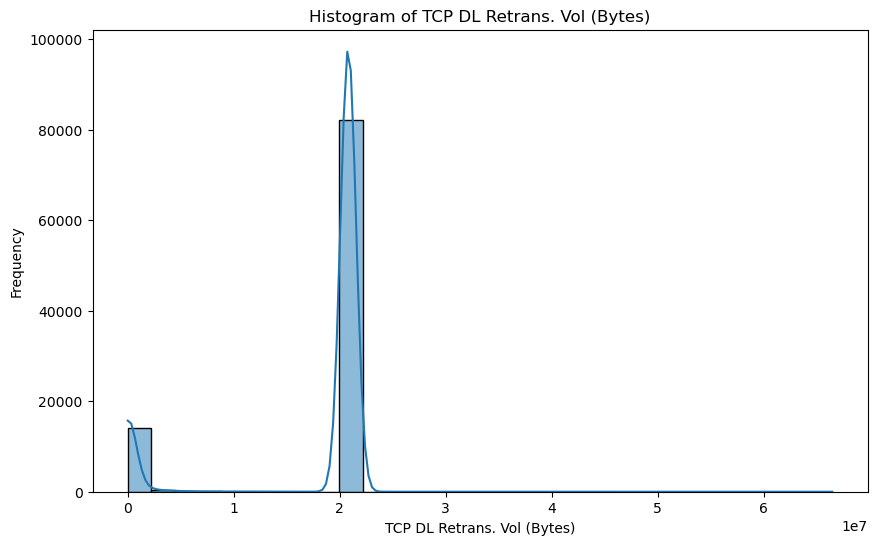

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


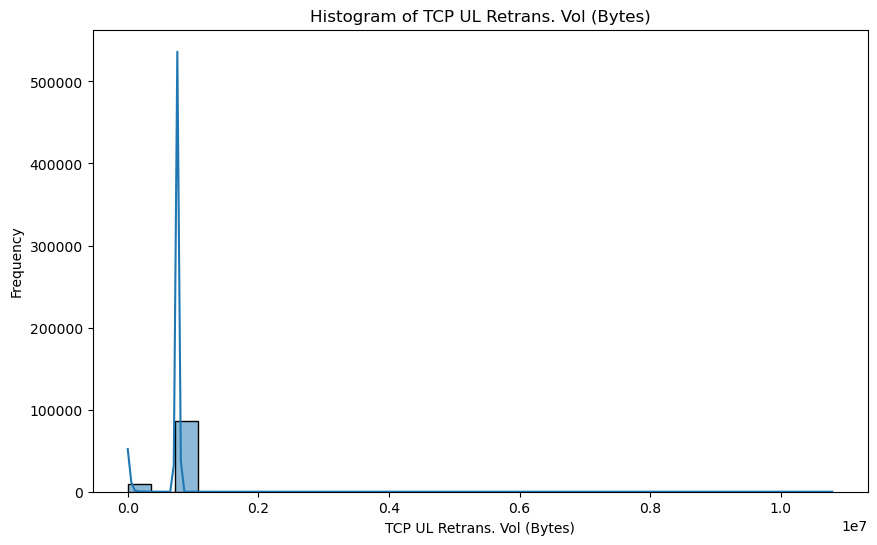

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


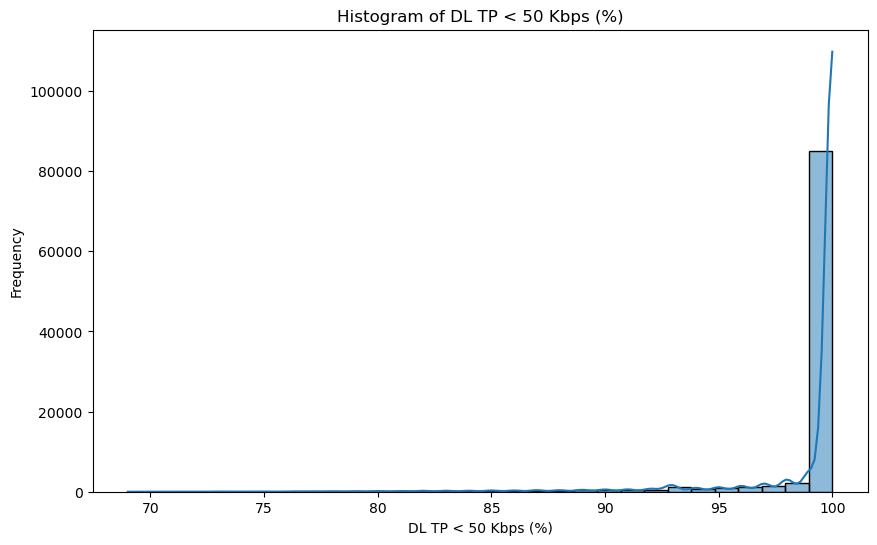

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


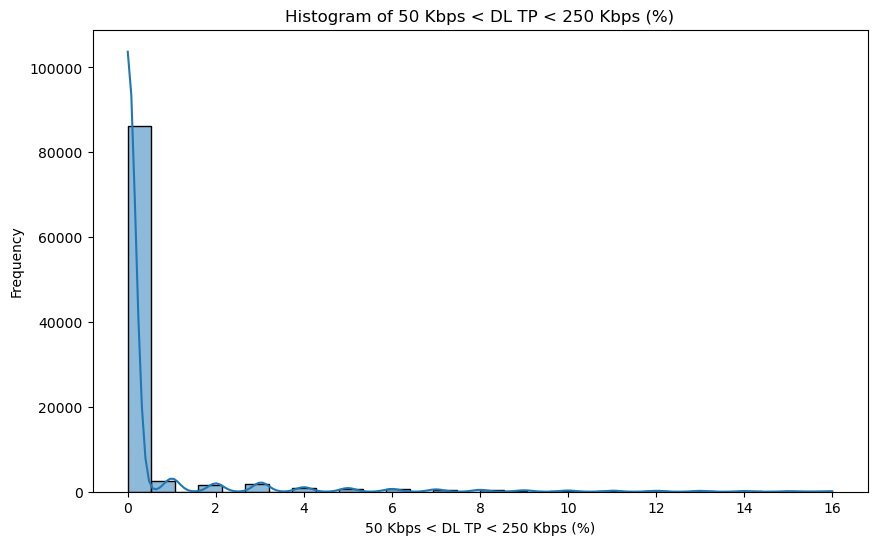

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


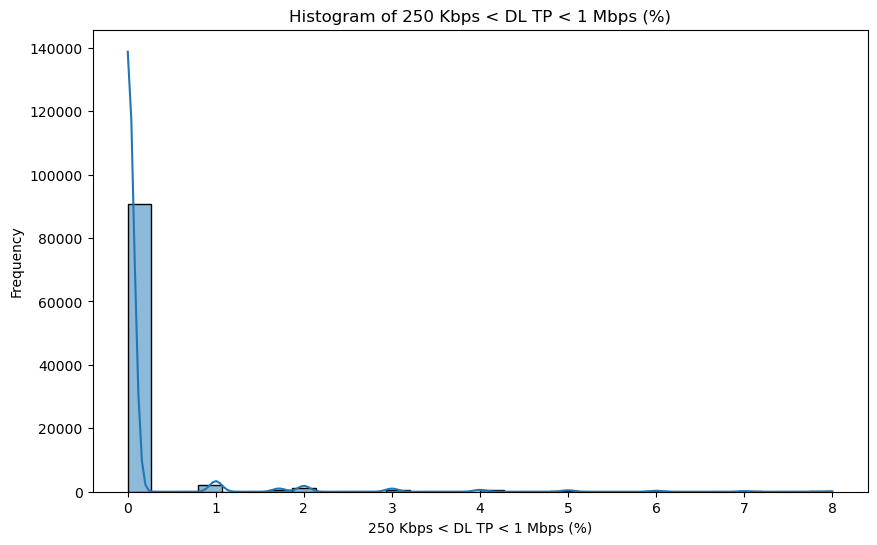

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


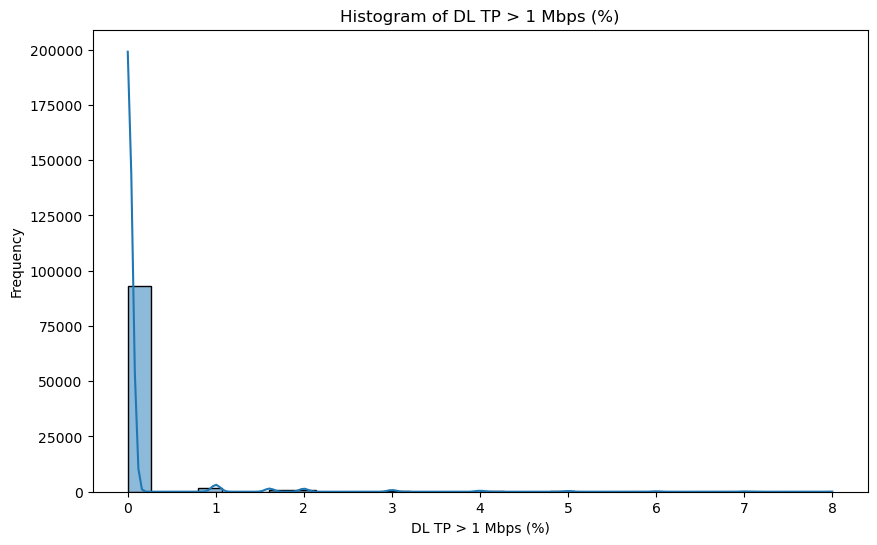

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


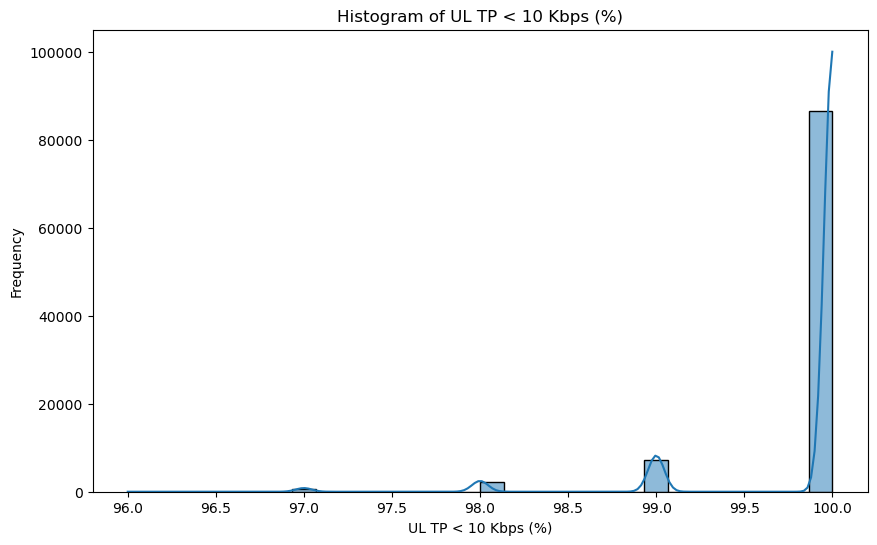

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


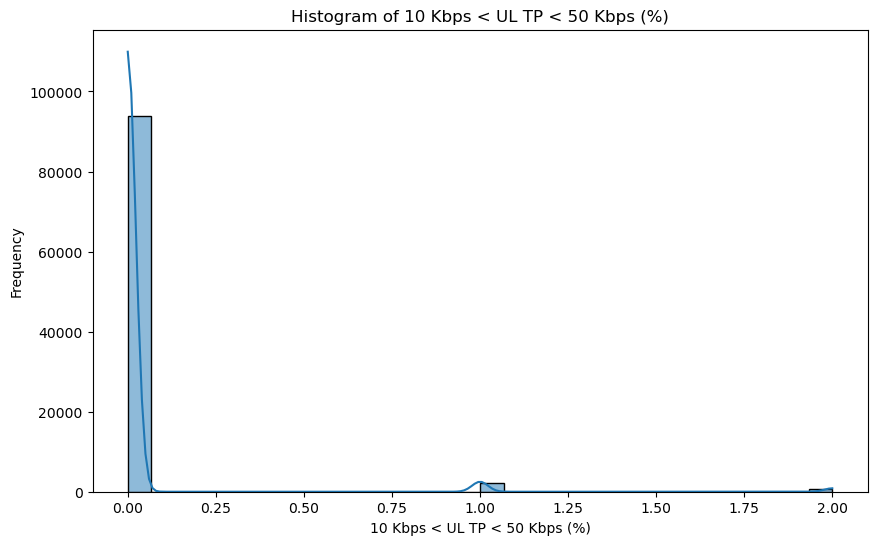

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


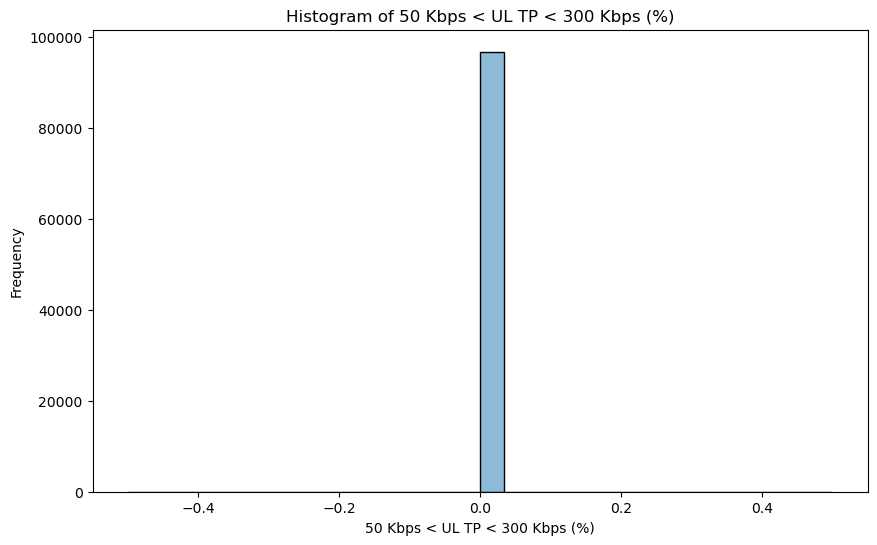

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


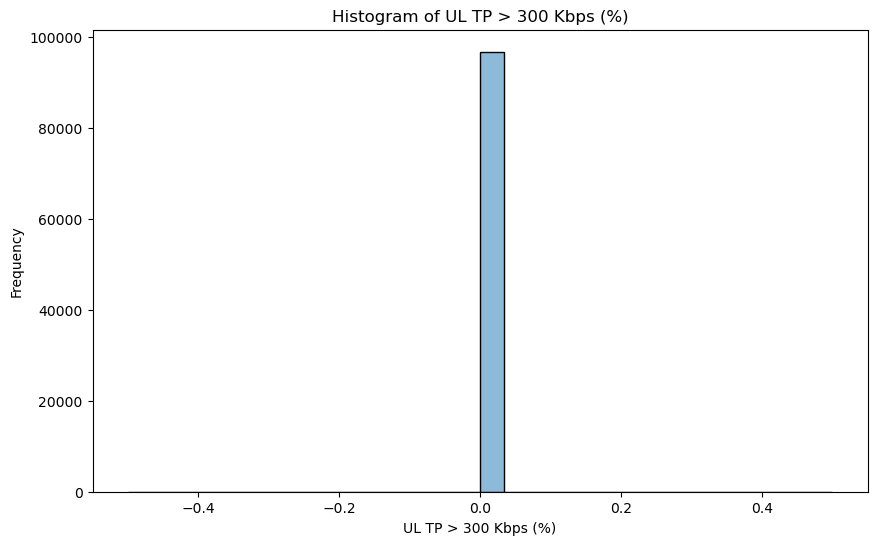

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


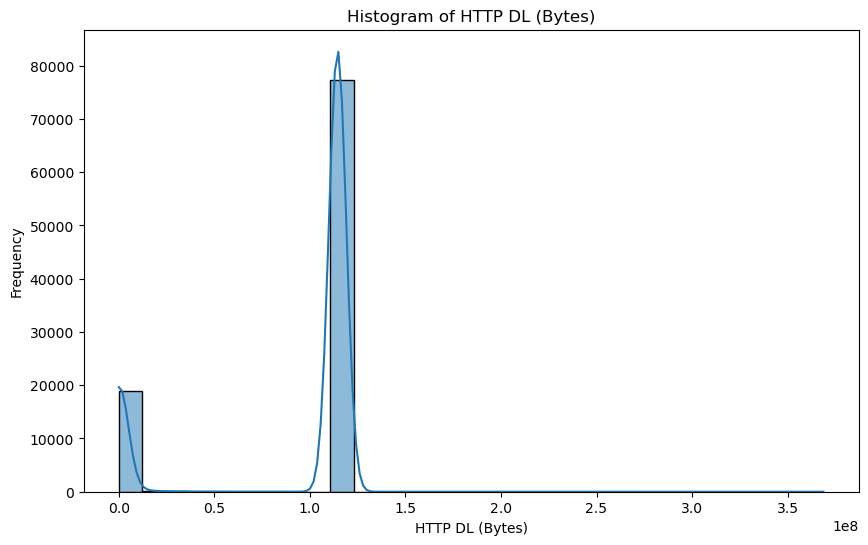

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


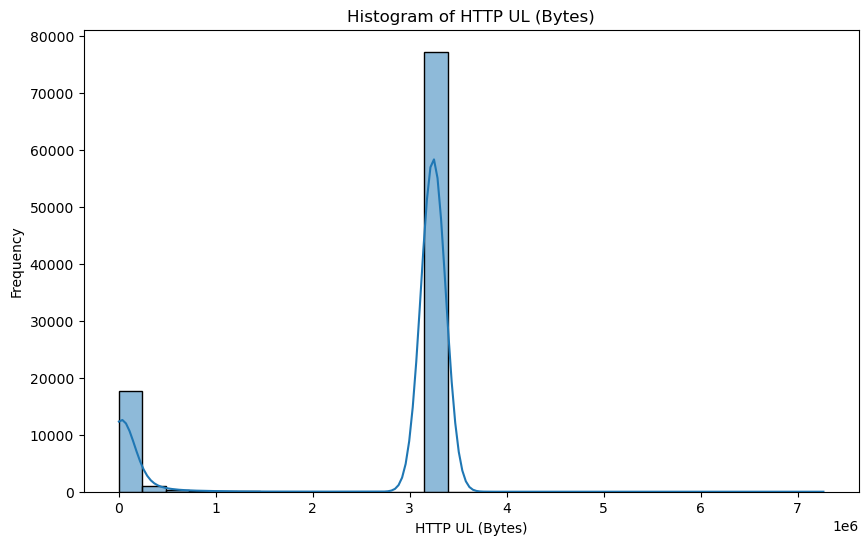

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


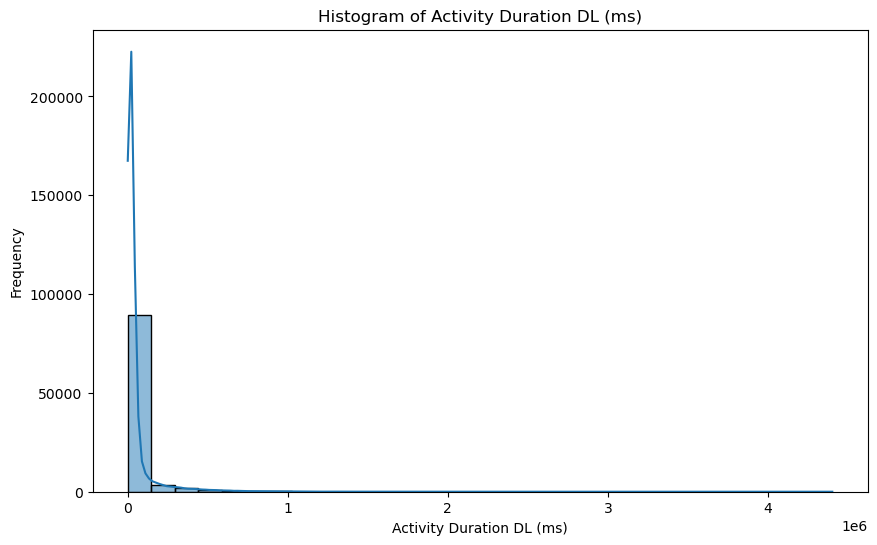

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


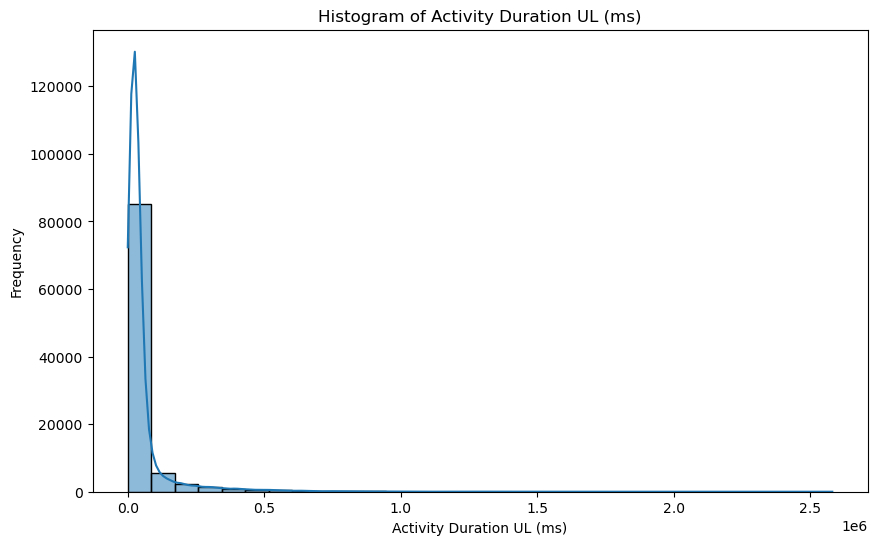

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


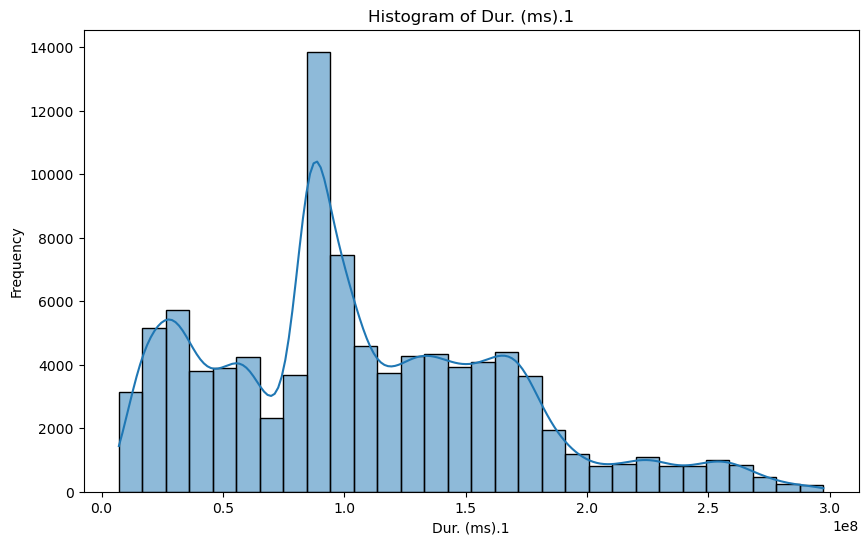

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


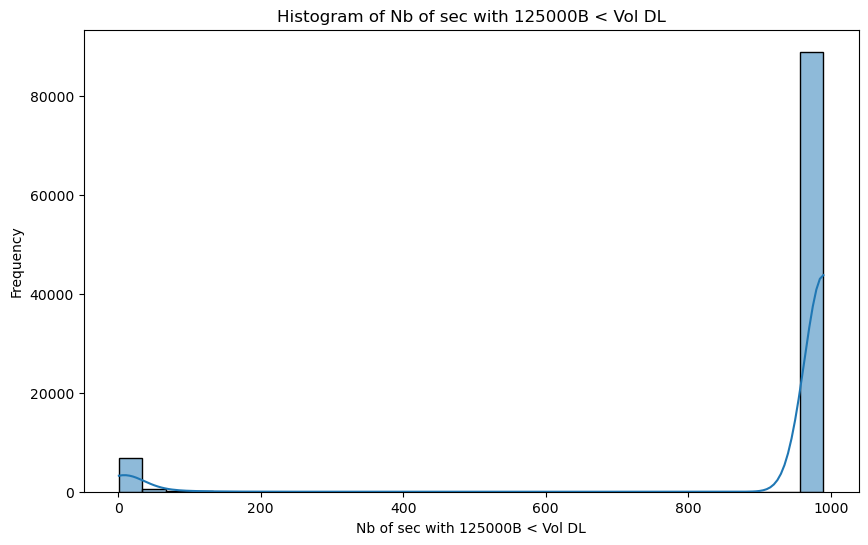

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


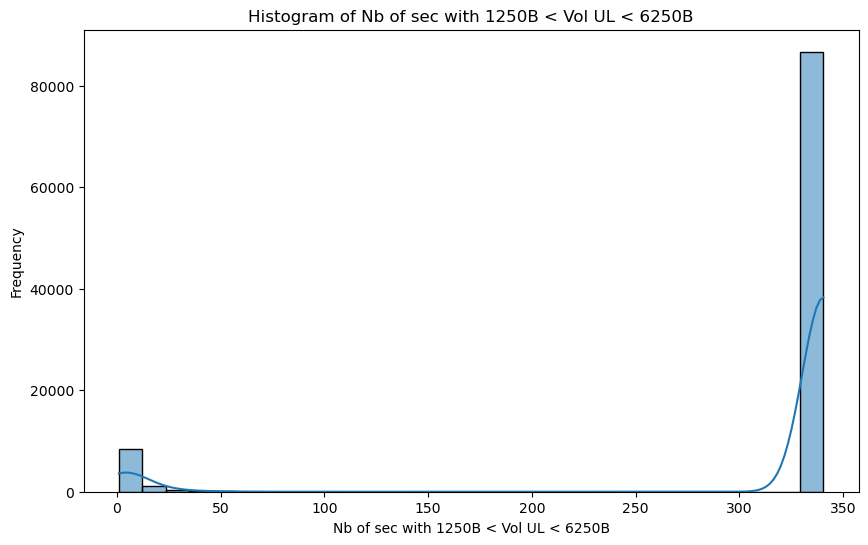

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


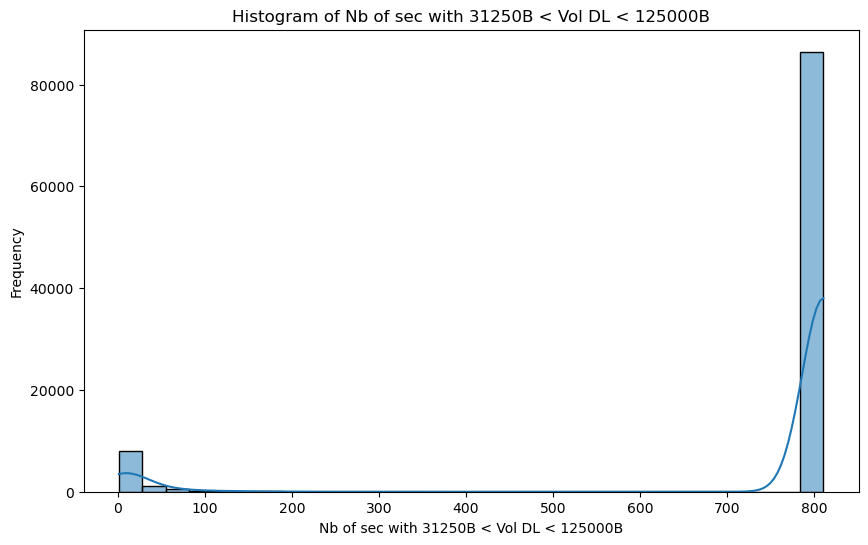

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


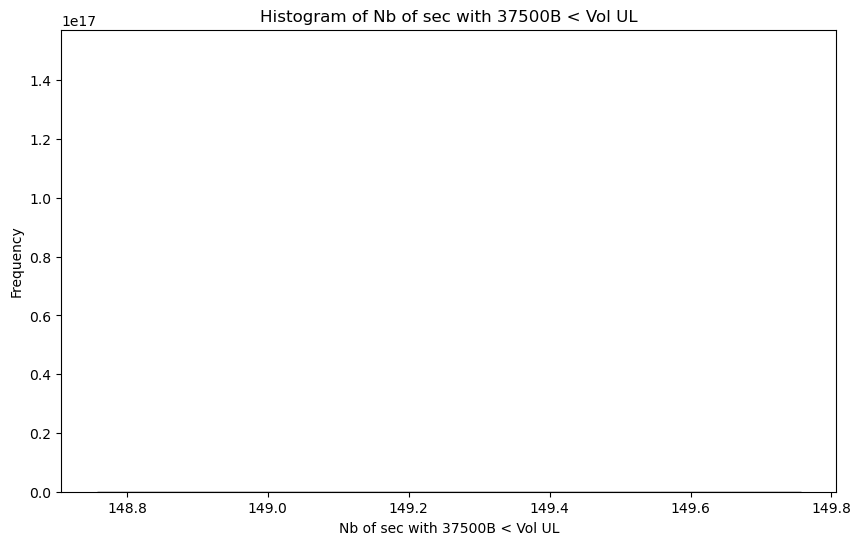

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


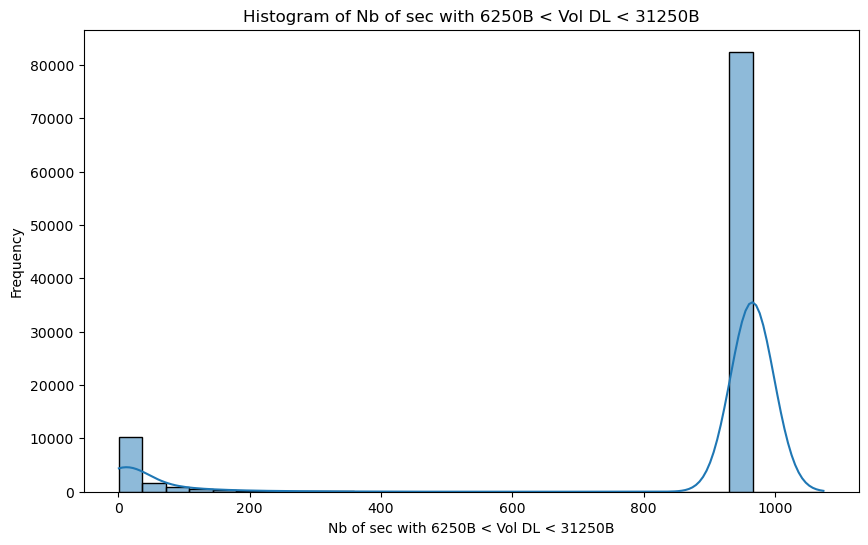

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


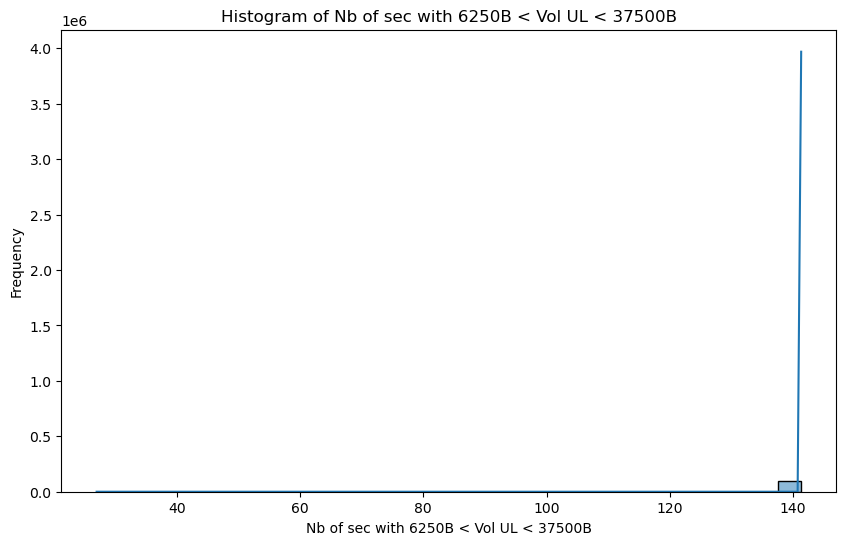

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


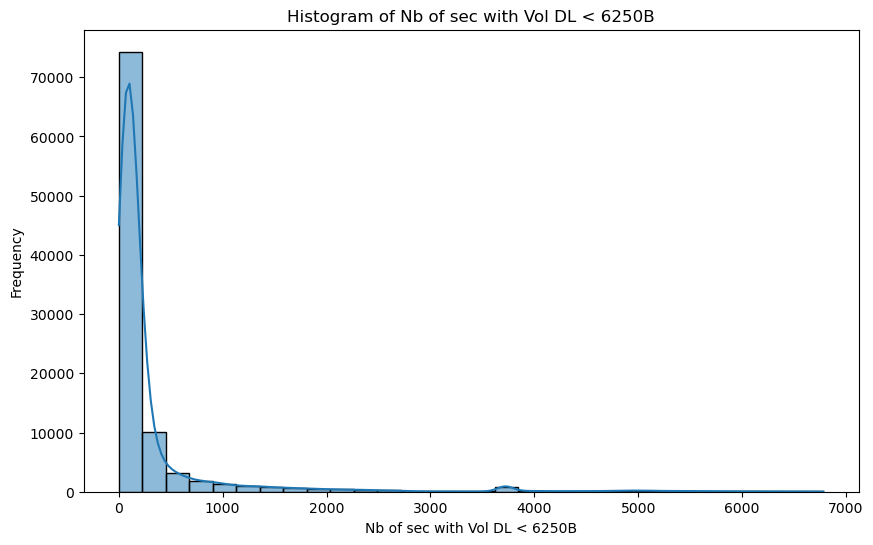

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


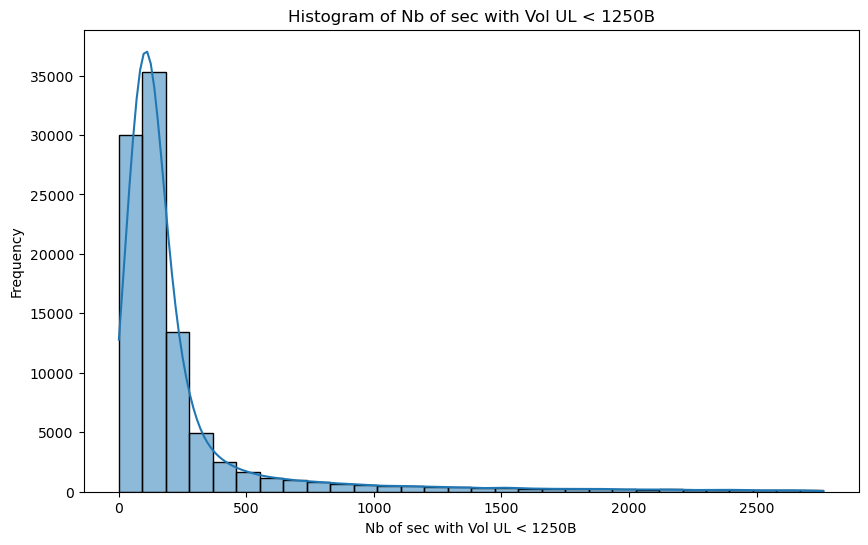

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


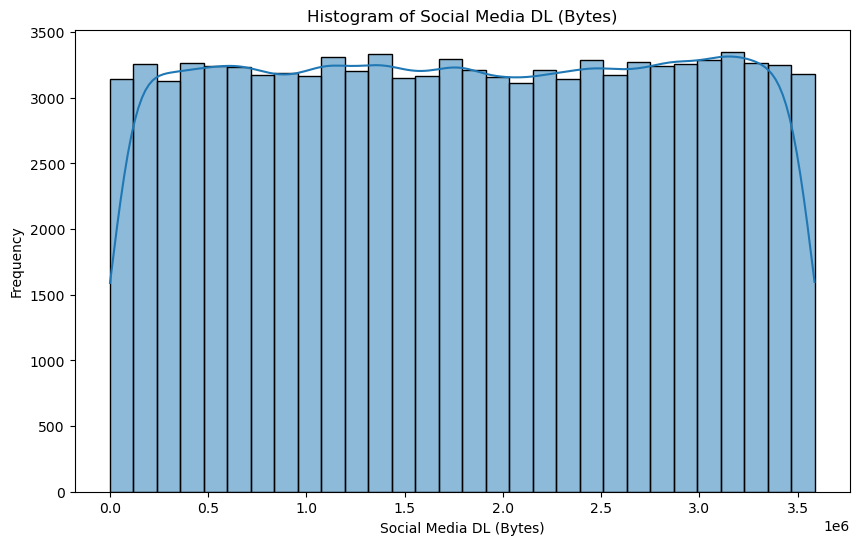

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


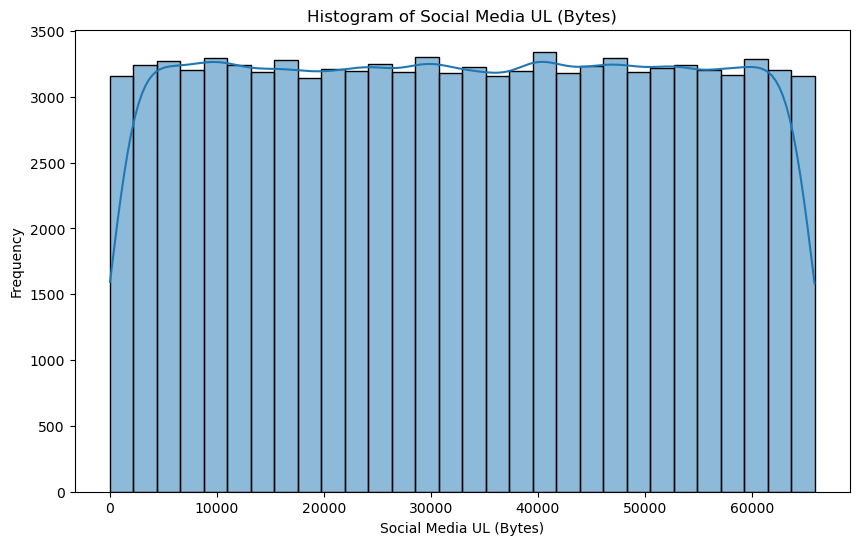

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


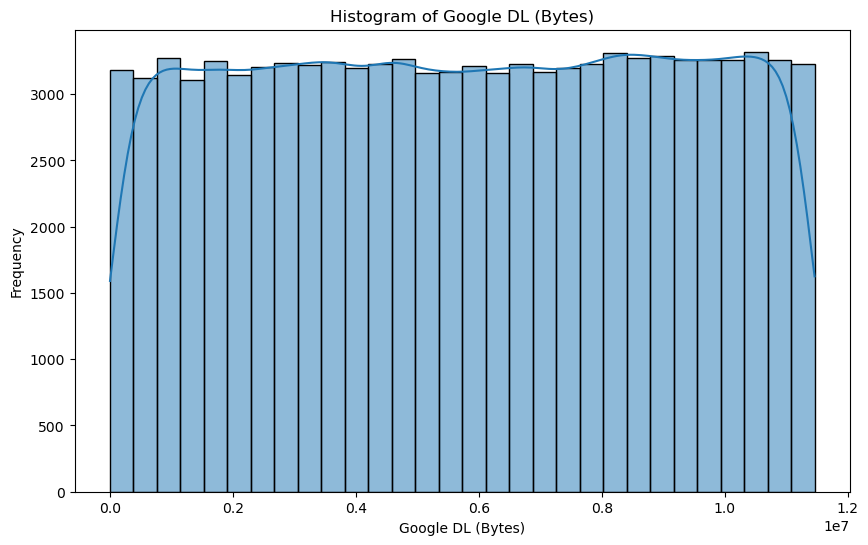

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


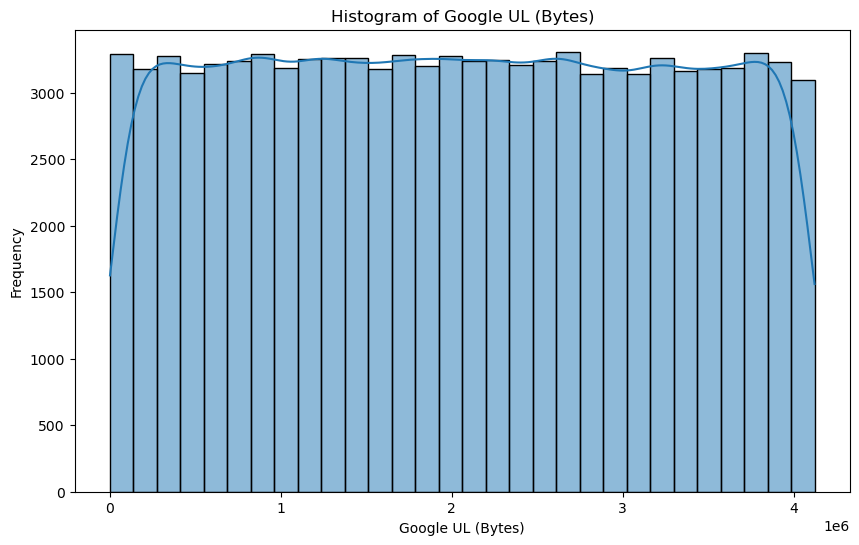

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


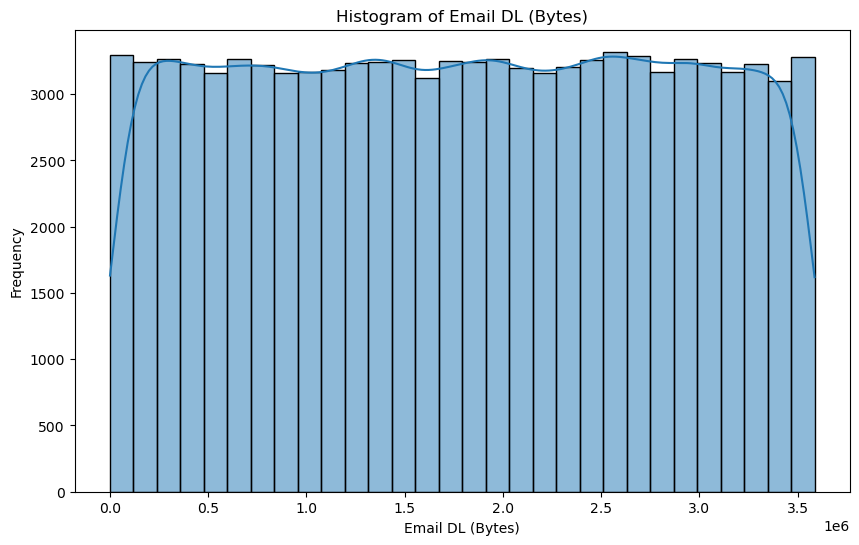

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


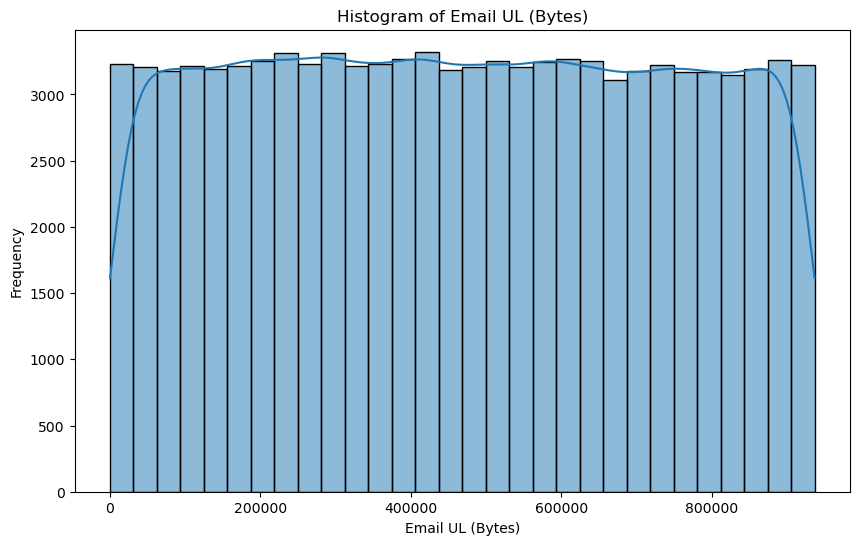

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


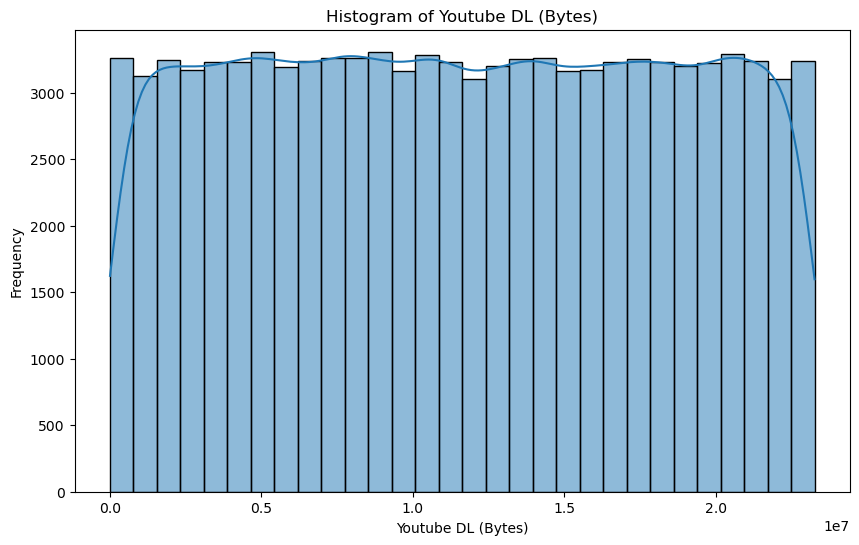

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


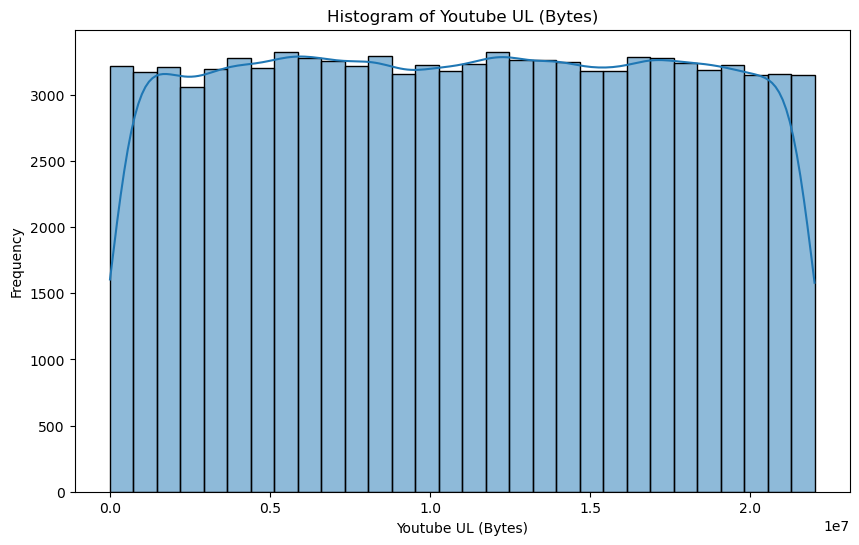

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


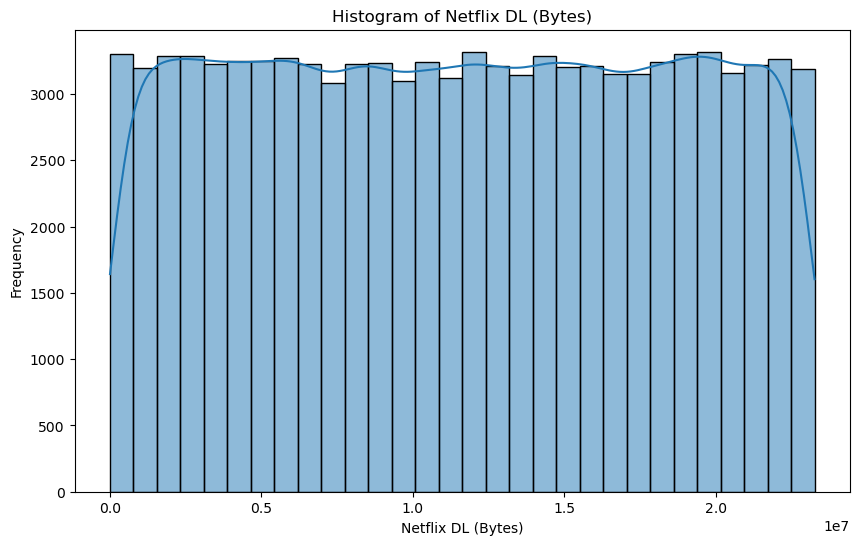

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


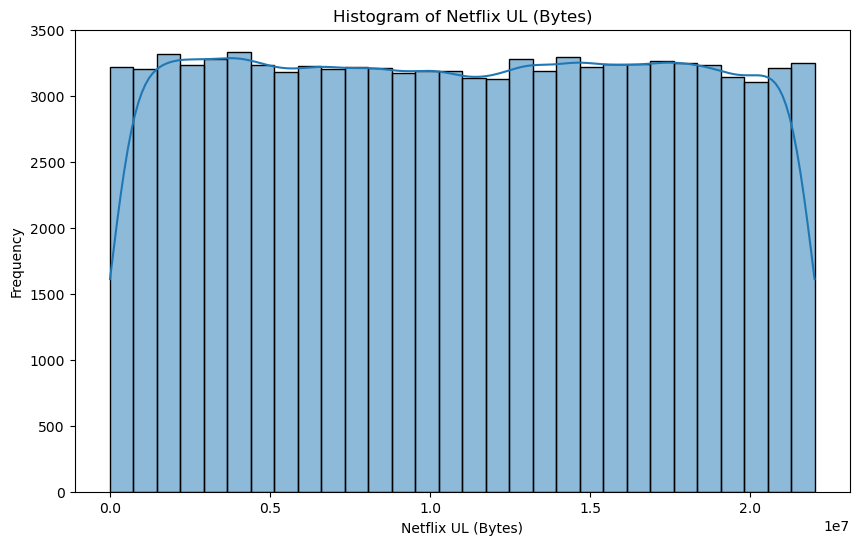

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


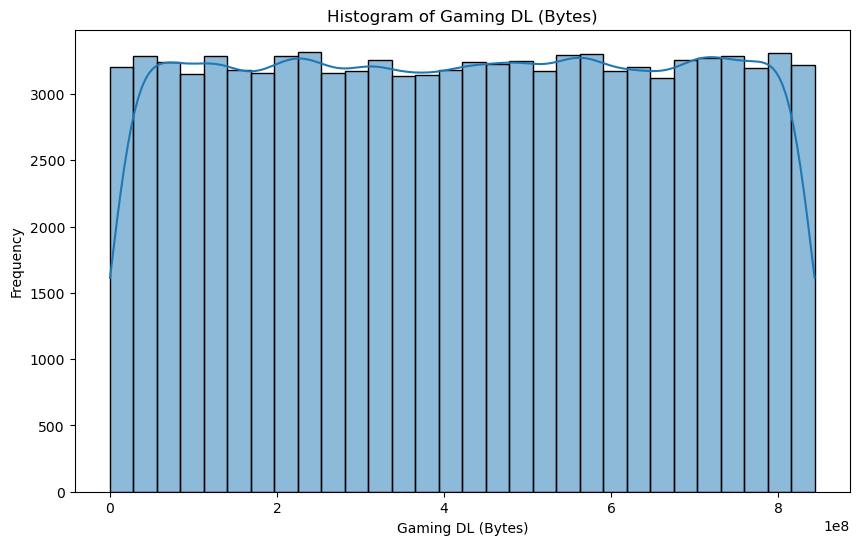

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


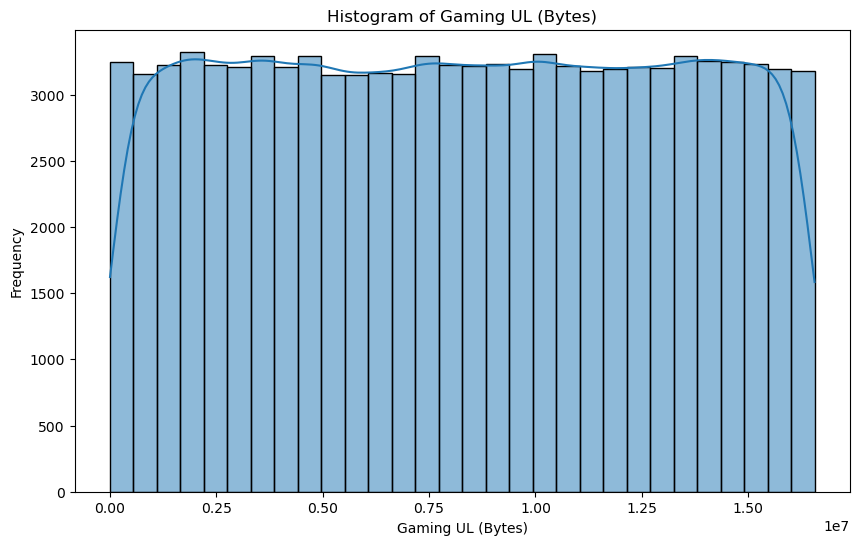

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


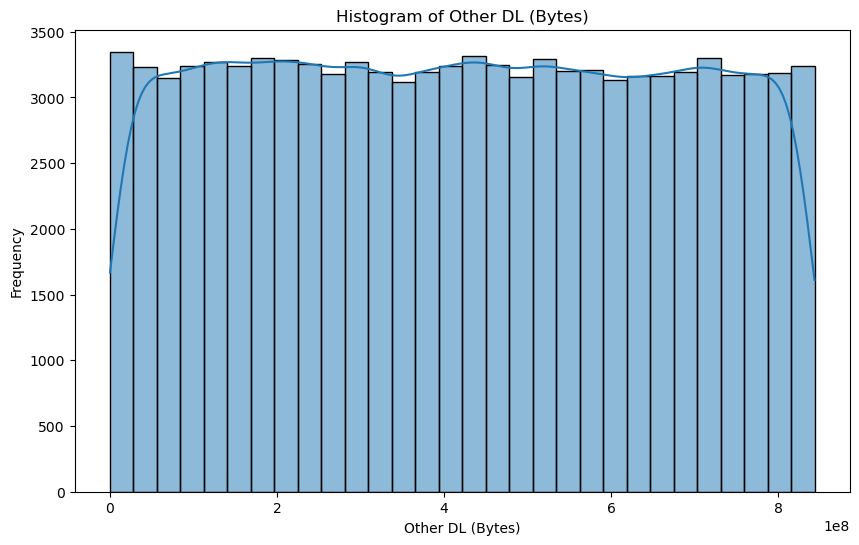

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


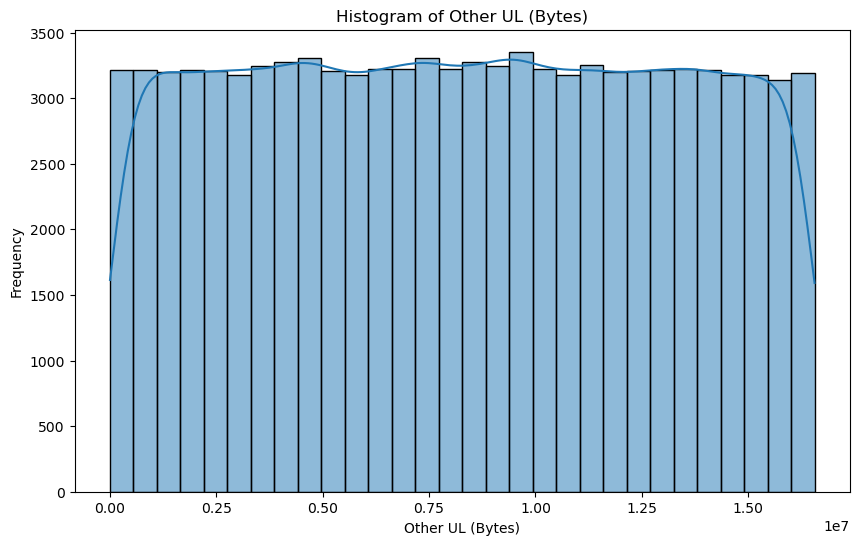

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


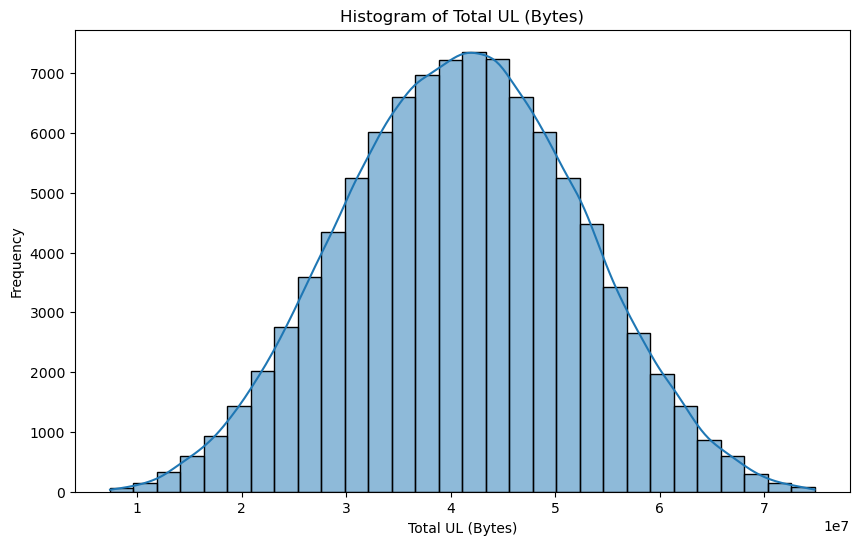

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


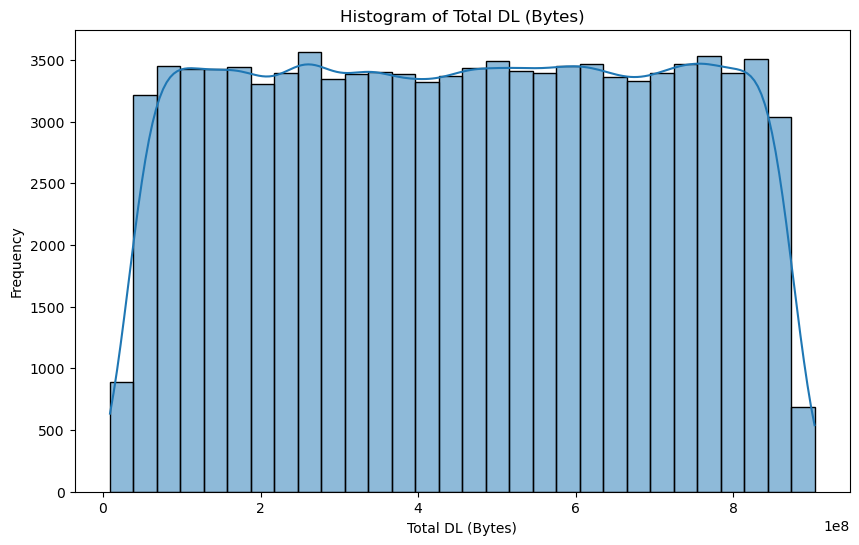

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


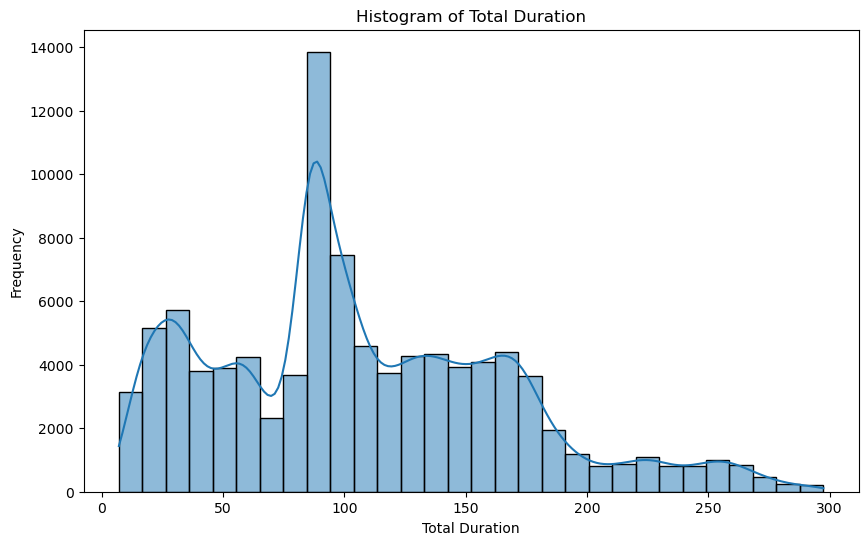

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


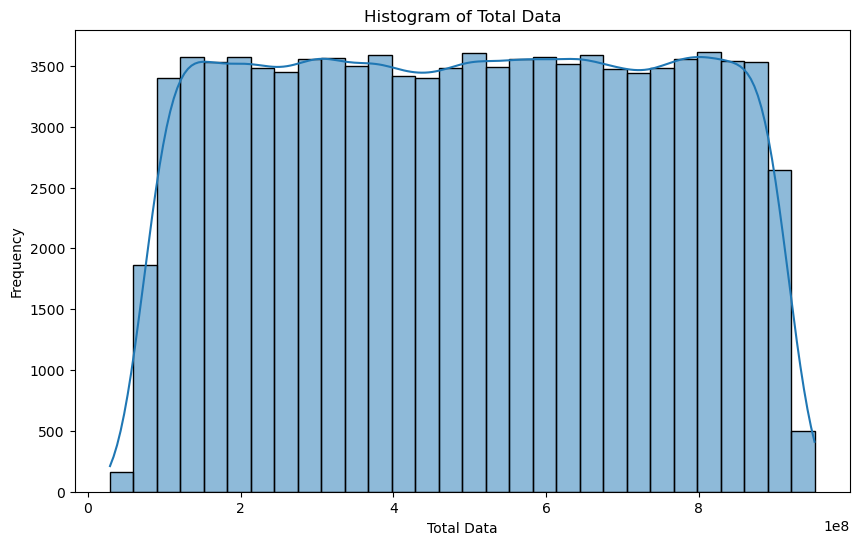

C:\Users\nejat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


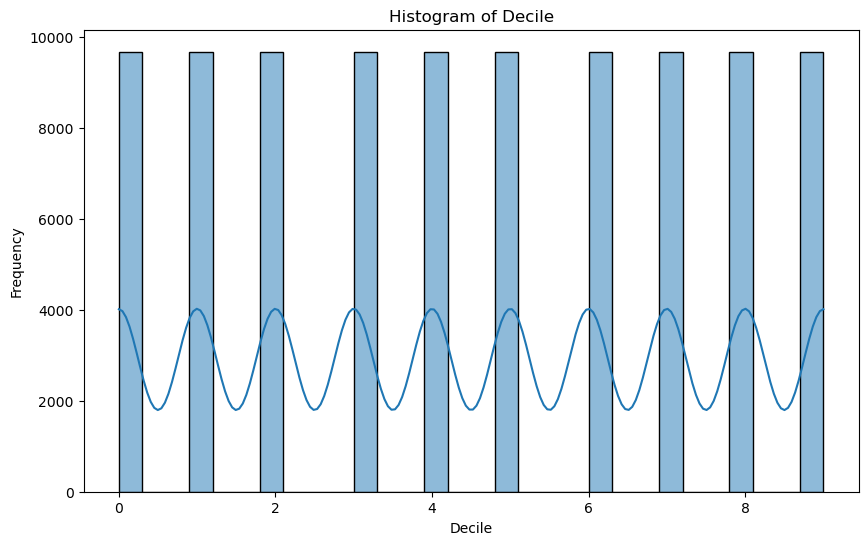

In [24]:
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

def graphical_univariate_analysis(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for column in numeric_cols:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[column].dropna(), bins=30, kde=True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

graphical_univariate_analysis(df)

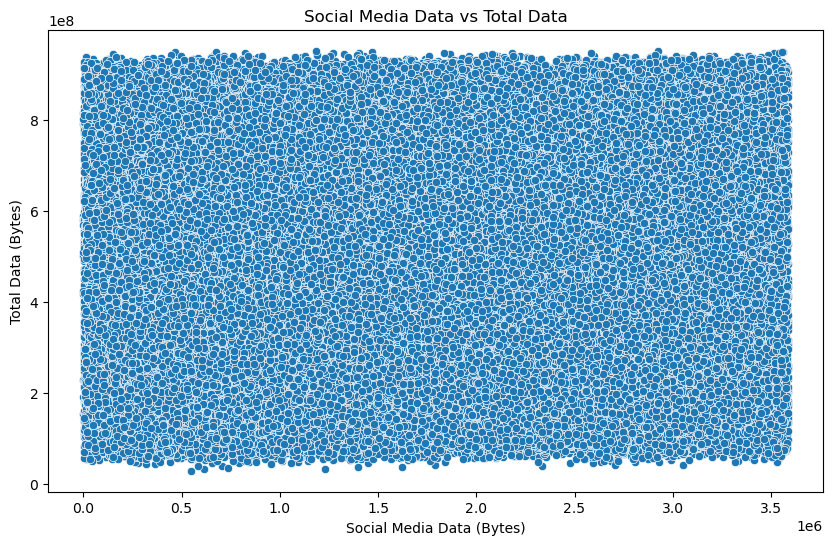

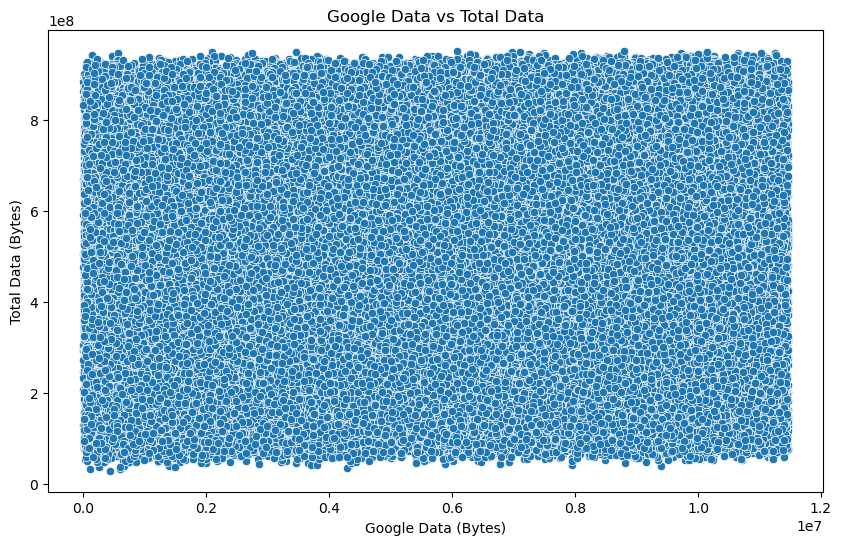

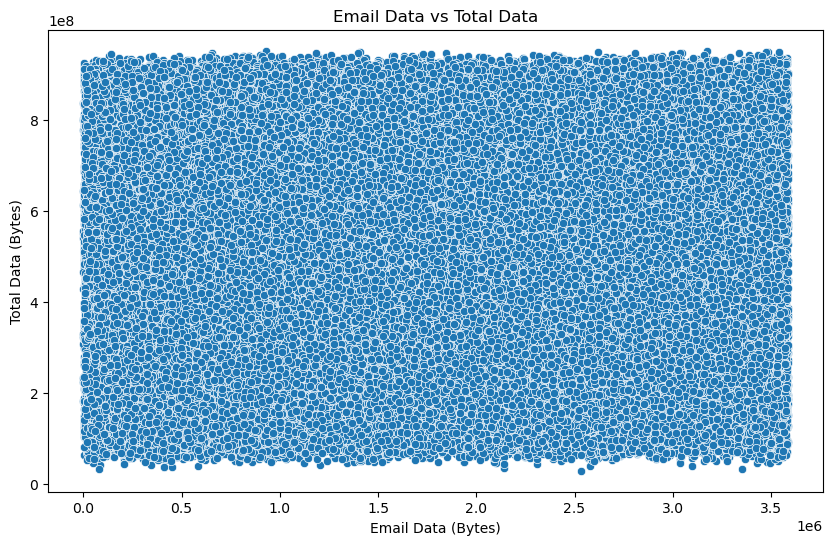

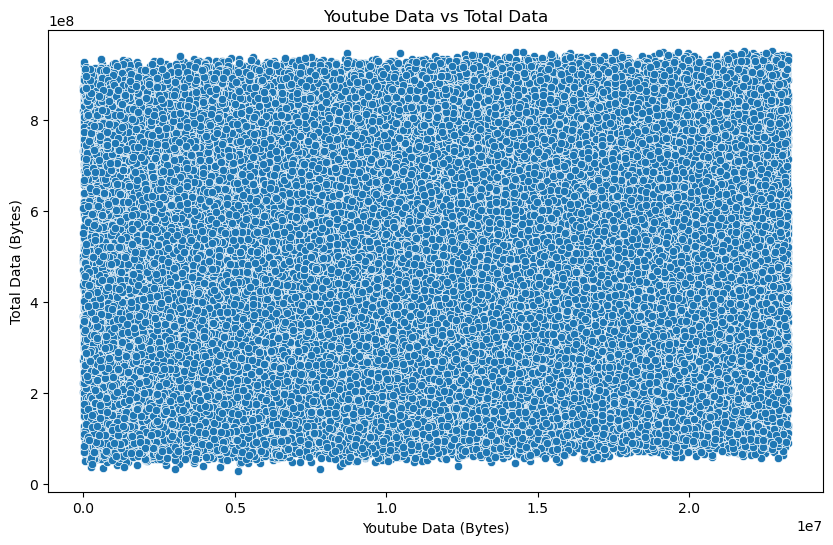

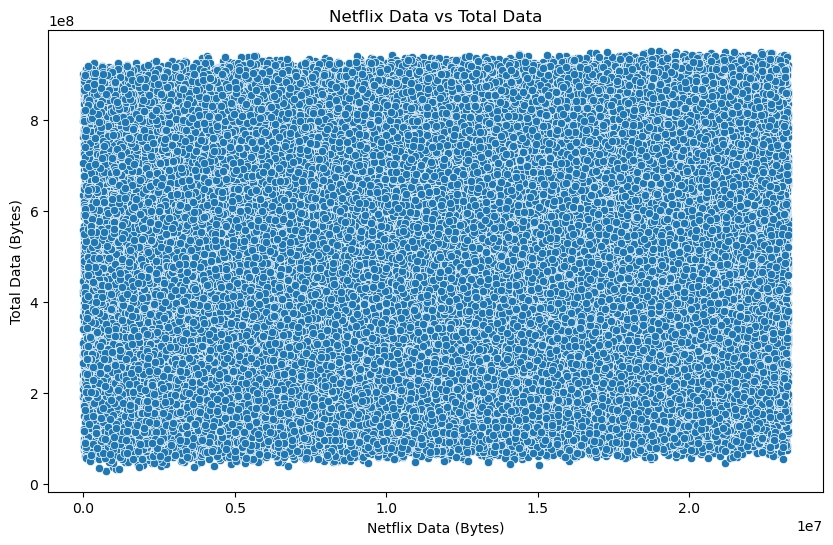

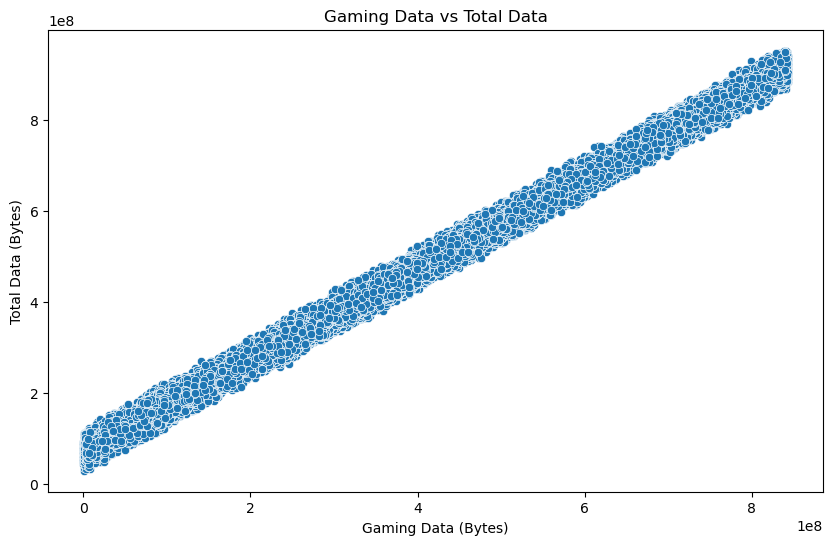

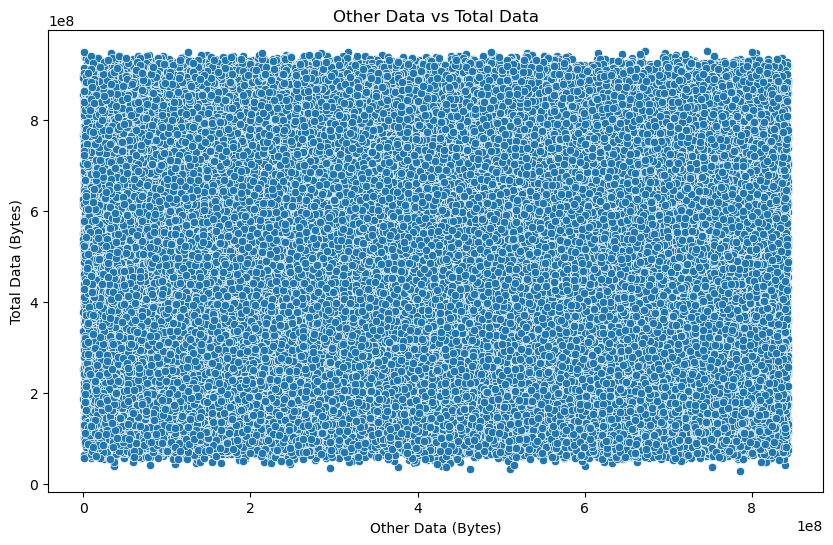

In [25]:
def bivariate_analysis(df):
    applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
    for app in applications:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=f'{app} DL (Bytes)', y='Total Data', data=df)
        plt.title(f'{app} Data vs Total Data')
        plt.xlabel(f'{app} Data (Bytes)')
        plt.ylabel('Total Data (Bytes)')
        plt.show()

bivariate_analysis(df)


Correlation Matrix:
                         Social Media DL (Bytes)  Google DL (Bytes)  \
Social Media DL (Bytes)                 1.000000          -0.003979   
Google DL (Bytes)                      -0.003979           1.000000   
Email DL (Bytes)                        0.006078          -0.001257   
Youtube DL (Bytes)                     -0.002001           0.000517   
Netflix DL (Bytes)                     -0.002949           0.004750   
Gaming DL (Bytes)                       0.000473          -0.003403   
Other DL (Bytes)                        0.005051          -0.003317   

                         Email DL (Bytes)  Youtube DL (Bytes)  \
Social Media DL (Bytes)          0.006078           -0.002001   
Google DL (Bytes)               -0.001257            0.000517   
Email DL (Bytes)                 1.000000            0.003732   
Youtube DL (Bytes)               0.003732            1.000000   
Netflix DL (Bytes)              -0.000328            0.003051   
Gaming DL (Bytes)   

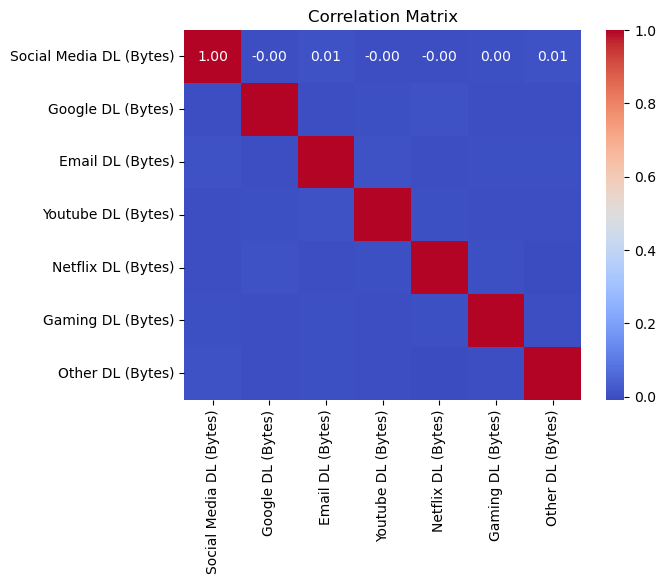

In [26]:
def correlation_analysis(df):
    correlation_matrix = df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)',
                             'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].corr()
    print("\nCorrelation Matrix:")
    print(correlation_matrix)
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

correlation_analysis(df)



Explained Variance Ratio:
[2.36559344e-01 7.19145318e-02 5.99939940e-02 3.98809319e-02
 3.73033240e-02 2.76884705e-02 2.44064580e-02 2.36528663e-02
 2.07894109e-02 2.06273938e-02 2.04430798e-02 2.03164585e-02
 2.02826952e-02 2.01816646e-02 2.01691970e-02 2.01196356e-02
 2.00210461e-02 1.99698326e-02 1.98861292e-02 1.98614411e-02
 1.97700926e-02 1.97385084e-02 1.97143050e-02 1.96322826e-02
 1.95733510e-02 1.92689298e-02 1.82392225e-02 1.75074034e-02
 1.25796862e-02 1.24533527e-02 1.00576405e-02 9.16442344e-03
 7.40348760e-03 5.86212502e-03 5.28447679e-03 4.71521622e-03
 3.65304706e-03 3.22740485e-03 2.94906805e-03 1.96514953e-03
 1.87107358e-03 1.03106222e-03 2.00831150e-04 5.53926360e-05
 1.45627564e-05 3.16915688e-13 4.66531045e-32 6.41595689e-33
 2.12721248e-33 1.65265451e-33 1.65265451e-33 1.65265451e-33
 1.65265451e-33]


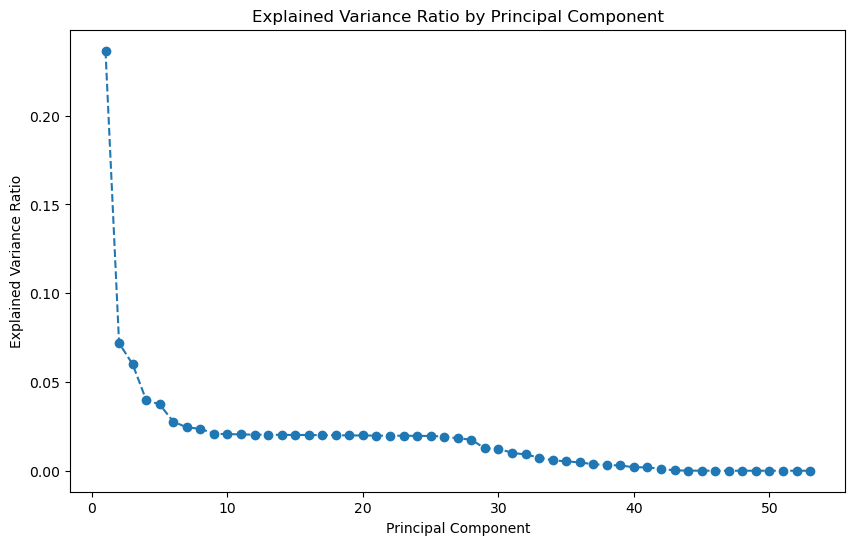

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def dimensionality_reduction(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numeric_cols].dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    explained_variance = pca.explained_variance_ratio_
    print("\nExplained Variance Ratio:")
    print(explained_variance)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.title('Explained Variance Ratio by Principal Component')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

dimensionality_reduction(df)